## Import Libraries

In [33]:
import os
import pandas as pd
import numpy as np
import json 

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
categorized_questions_file = 'categorized_questions.jsonl'

# read categorized questions
categorized_questions = []
with open(categorized_questions_file, 'r') as f:
    for line in f:
        categorized_questions.append(json.loads(line))

# check if common_questions are same as categorized_questions
categorized_questions_list = [list(q.values())[0] for q in categorized_questions]

# create a dictionary to map questions to their categories
question_to_category = {q['Question']: q['Category'] for q in categorized_questions}

## Load Dataset

#### Load of the CSV Data
- CSV Data: CSV Files for 17 countries
- Dollarstreet data is excluded because it is across more countries.

In [36]:
import pandas as pd
from scipy.spatial import distance
import ast

# List all files in the directory
# directory = "/home/vsl333/cultural_values/notebooks/outputs"
# exclude file ending with _peoplle_results.csv
files = ['outputs/cvqa_wvs_metadata_test_False_results.csv', 'outputs/ds_wvs_metadata_test_True_results.csv']
print(len(files))


2


In [37]:
cvqa_image_data = pd.read_csv(files[0])
ds_country_data = pd.read_csv(files[1])

# rest index
cvqa_image_data.reset_index(drop=True, inplace=True)
ds_country_data.reset_index(drop=True, inplace=True)

Select row with common countries

In [18]:
ds_country_data.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers'],
      dtype='object')

In [19]:
cvqa_image_data.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers'],
      dtype='object')

In [55]:
print(cvqa_image_data.shape)
# remove the row where prob_percent_values = 0
cvqa_image_data = cvqa_image_data[cvqa_image_data['prob_percent_values'] != '0']
print(cvqa_image_data.shape)

(13217, 19)
(13216, 19)


In [57]:
common_countries = set(cvqa_image_data['country'].values).intersection(set(ds_country_data['country'].values))
print(common_countries)

{'Italy', 'Vietnam', 'Nigeria', 'France', 'Mexico', 'China', 'Pakistan', 'Brazil'}


In [58]:
# Filter the data to only include the common countries
cvqa_image_data = cvqa_image_data[cvqa_image_data['country'].isin(common_countries)]
ds_country_data = ds_country_data[ds_country_data['country'].isin(common_countries)]

# rest index
cvqa_image_data.reset_index(drop=True, inplace=True)
ds_country_data.reset_index(drop=True, inplace=True)

### Map question to thieir question category

In [59]:
# add a new column 'Category' to data_1 and data_2 based on the question_text
# set width of pandas
ds_country_data['question_topic'] = ds_country_data['question_text'].map(question_to_category)
cvqa_image_data['question_topic'] = cvqa_image_data['question_text'].map(question_to_category)

pd.set_option('display.max_colwidth', 300)
# only dsiplay question_text and question_topic columns
cvqa_image_data[['question_text', 'question_topic']].head(3)


,question_text,question_topic
0,"In your view, how often do the following things occur in this country’s elections?\n\nOpposition candidates are prevented from running",O. Regions and countries
1,Which of the following things have you done for reasons of security?\n\nDidn’t carry much money,Q. Security
2,"Now I am going to read out a list of voluntary organizations; for each one, could you tell me whether you are a member, an active member, an inactive member or not a member of that type of organization?\n\nArt, music or educational organization",P. Methodological research


#### Compute JSD and Similarity for Countries (across all categories)
- JSD: Jensen Shannon Divergence
- Similarity is computed as 1 - JSD

In [94]:
results = []

for idx, each_data in enumerate([ds_country_data, cvqa_image_data]):
    data = each_data.copy()

    # Add category column to the DataFrame
    data['category'] = data['image_path'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[1:-2])
    data['category'] = data['category'].apply(lambda x: '_'.join(x))

    # Example gt and pred (list of lists)
    gt = [ast.literal_eval(x) for x in each_data['selection_answers'].tolist()] # there are prob distrbutions of human answers
    pred = [ast.literal_eval(x) for x in each_data['prob_percent_values'].tolist()] # there are prob distrbutions of model answers

    # Original DataFrame, retaining all columns from `data`
    df = data.copy()

    # Keep track of matching indices
    breakpoint()
    matching_indices = [i for i, (g, p) in enumerate(zip(gt, pred)) if len(g) == len(p)]

    # Filter rows where len(g) == len(p)
    filtered_gt_pred = [(g, p) for g, p in zip(gt, pred) if len(g) == len(p)]

    # If there are any matching rows
    if filtered_gt_pred:
        gt_filtered, pred_filtered = zip(*filtered_gt_pred)

        # Calculate JSD
        jsd = [distance.jensenshannon(g, p) for g, p in zip(gt_filtered, pred_filtered)]
        similarity = [1 - value for value in jsd]

        try:
            # Add JSD and similarity values back to the DataFrame
            df.loc[matching_indices, 'jsd'] = jsd
            df.loc[matching_indices, 'similarity'] = similarity
        except Exception as e:
            print(f"Error processing JSD and similarity for indices {matching_indices}: {e}")
            breakpoint()
    else:
        df['jsd'] = None  # or handle the case accordingly
        df['similarity'] = None

    # Set JSD and similarity to NaN or a placeholder for rows that were filtered out
    df['jsd'] = pd.to_numeric(df['jsd'], errors='coerce')
    df['similarity'] = pd.to_numeric(df['similarity'], errors='coerce')

    if idx == 0:
        df['Image'] = 'False'
    else:
        df['Image'] = 'True'

    # Calculate mean of jsd and similarity per country per 'Image' column and add new col 'mean_jsd' and 'mean_similarity'
    df['country_mean_jsd'] = df.groupby(['country', 'Image'])['jsd'].transform('mean')
    df['coutry_mean_similarity'] = df.groupby(['country', 'Image'])['similarity'].transform('mean')

    # Append results to list
    results.append(df)

# Combine all results into a single DataFrame
final_result = pd.concat(results)

In [62]:
# final_result.head(3)

Country Order

In [95]:
rich_countries = ["Russia", "Romania", "France", "Spain", "South Korea", "Italy"]
medium_countries = ["Brazil", "Indonesia", "Mexico", "Philippines", "Mongolia", "China", "Colombia"]
poor_countries = ["Pakistan","Ethiopia", "Nigeria", "Egypt", "Kenya"]

country_list = rich_countries + medium_countries + poor_countries

#### Separate by  question categories

In [96]:
unique_countries = final_result['country'].unique()
unique_countries

array(['Brazil', 'China', 'France', 'Italy', 'Mexico', 'Nigeria',
       'Pakistan', 'Vietnam'], dtype=object)

In [97]:

results_country_order = [country for country in country_list if country in unique_countries]
results_country_order

['France', 'Italy', 'Brazil', 'Mexico', 'China', 'Pakistan', 'Nigeria']

In [99]:
# for each question_topic, calculate mean of jsd and similarity per country and save as different df 
# save all dfs in a dictionary

import shutil
question_outputs_dir = 'outputs_cvqa_ques_category'

# delete directory if already exist
if os.path.exists(question_outputs_dir):
    shutil.rmtree(question_outputs_dir)
    print(f"Existed! Deleted {question_outputs_dir} directory")

# create directory
os.makedirs(question_outputs_dir)
print(f"Created {question_outputs_dir} directory")  

# save final_result as csv
final_result.to_csv(f"{question_outputs_dir}/all_category_results.csv", index=False)

df_category_similarity = {}

for category in final_result['question_topic'].unique():
    df_category = final_result[final_result['question_topic'] == category]

    # calculate mean of jsd and similarity per country
    df_category['question_topic_mean_jsd'] = df_category.groupby(['country', 'Image'])['jsd'].transform('mean')
    df_category['question_topic_mean_similarity'] = df_category.groupby(['country', 'Image'])['similarity'].transform('mean')

    df_category_similarity[category] = df_category

    df_category_similarity[category].to_csv(f"{question_outputs_dir}/{category}_results.csv", index=False)


Existed! Deleted outputs_cvqa_ques_category directory
Created outputs_cvqa_ques_category directory


### See similaity per question category

In [100]:
df_category_similarity.keys()

dict_keys(['J. News habits and media', 'P. Methodological research', 'M. Race and ethnicity', 'O. Regions and countries', 'D. Politics and policy', 'N. Economy and work', 'L. Family and relationships', 'K. Immigration and migration', 'I. Gender and LGBTQ', 'B. Religion and spirituality', 'E. Demographics', 'C. Science and technology', 'Q. Security', 'G. International affairs', 'A. Social values and attitudes'])

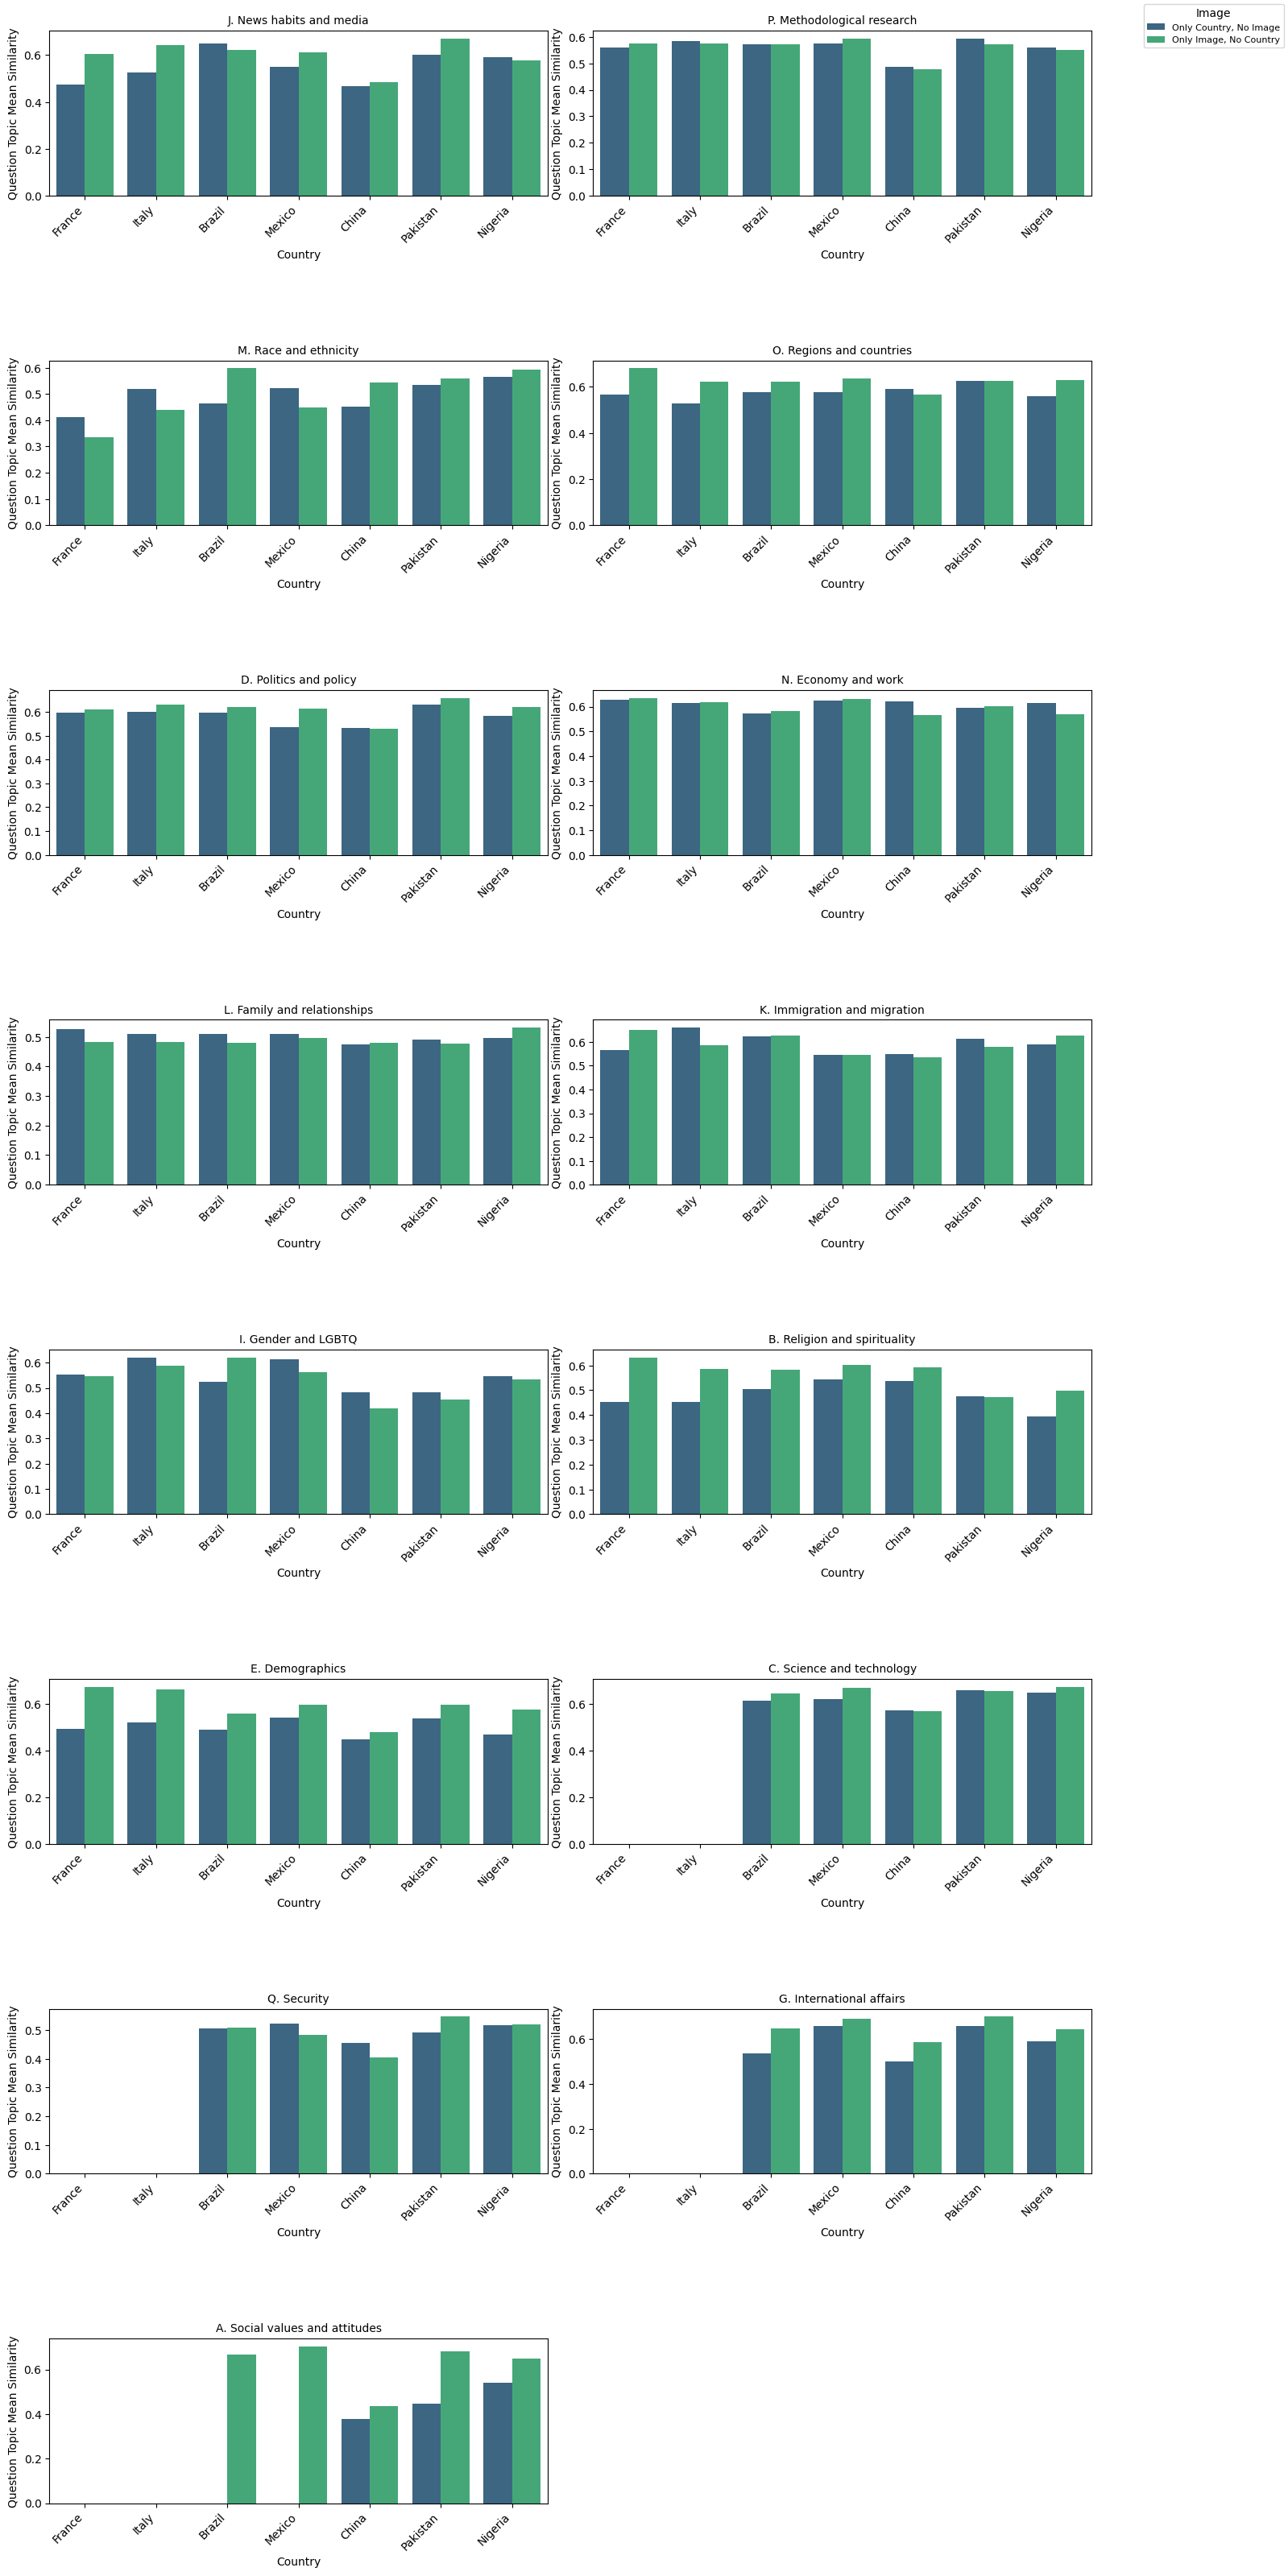

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get the unique categories
categories = df_category_similarity.keys()

# Determine the number of subplots needed
num_categories = len(categories)
num_cols = 2
num_rows = (num_categories + 1) // num_cols

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Initialize variables for the legend
legend_handles = None
legend_labels = None

# Iterate through each category and create a subplot
for idx, category in enumerate(categories):
    ax = axes[idx]
    
    # Get the dataframe for the current category
    cat_df = df_category_similarity[category]
    
    # Filter and sort the dataframe
    cat_df = cat_df[['country', 'question_topic_mean_jsd', 'question_topic_mean_similarity', 'Image']].drop_duplicates()
    cat_df = cat_df.sort_values(['country', 'Image'])
    
    # Filter cat_df to only include countries in results_country_order
    cat_df = cat_df[cat_df['country'].isin(results_country_order)]
    
    # If cat_df is empty, skip this plot
    if cat_df.empty:
        # Remove the axis
        fig.delaxes(ax)
        continue
    
    # Set 'country' as a categorical variable with ordered categories
    cat_df['country'] = pd.Categorical(cat_df['country'], categories=results_country_order, ordered=True)
    
    # Sort cat_df by 'country' to ensure correct order
    cat_df = cat_df.sort_values('country')
    
    # Create a bar plot
    sns.barplot(
        x='country',
        y='question_topic_mean_similarity',
        hue='Image',
        data=cat_df,
        palette='viridis',
        ax=ax
    )
    
    # Collect legend handles and labels from the first subplot
    if legend_handles is None:
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ['Only Country, No Image' if label == 'False' else 'Only Image, No Country' for label in labels]
        legend_handles = handles
        legend_labels = new_labels
    
    # Remove legend from the subplot
    ax.get_legend().remove()
    
    # Add labels and title
    ax.set_xlabel('Country')
    ax.set_ylabel('Question Topic Mean Similarity')
    ax.set_title(f'{category}', fontsize=10)
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
# Remove any unused subplots
for idx in range(num_categories, len(axes)):
    fig.delaxes(axes[idx])

# Add a single legend to the figure
fig.legend(legend_handles, legend_labels, title='Image', fontsize=8, loc='upper right')

# Adjust layout with vertical space between subplots
plt.tight_layout()
plt.subplots_adjust(hspace=1, right=0.85)  # Adjust 'right' to make space for the legend
plt.show()


#### Sort countries in order of income (High Income to Low Income)

In [187]:
# rich_countries = ["Russia", "Romania", "France", "Spain", "South Korea"]
# medium_countries = ["Brazil", "Indonesia", "Mexico", "Philippines", "Mongolia", "China", "Colombia"]
# poor_countries = ["Ethiopia", "Nigeria", "Egypt", "Kenya", "Pakistan"]


# country_order= rich_countries + medium_countries + poor_countries 
# print(len(country_order))
# # sort final result by country_order and put it in a new dataframe
# final_result_sorted = final_result.set_index('country').loc[country_order].reset_index()
# final_result_sorted

17


,country,jsd,similarity
0,Russia,0.417080,0.582920
1,Romania,0.391510,0.608490
2,France,0.415819,0.584181
3,Spain,0.412742,0.587258
4,South Korea,0.500548,0.499452
5,Brazil,0.418051,0.581949
6,Indonesia,0.490806,0.509194
7,Mexico,0.416823,0.583177
8,Philippines,0.511297,0.488703
9,Mongolia,0.451727,0.548273


### Set the color palette for Countries Mapped to Income Level

In [188]:
country_mapping = {}
for country in rich_countries:
    country_mapping[country] = 'rich'
for country in medium_countries:
    country_mapping[country] = 'medium'
for country in poor_countries:
    country_mapping[country] = 'poor'

# Define a color palette for the categories
# Define a color palette for the categories
category_palette = {
    'rich': 'darkgreen',
    'medium': 'lightgreen',
    'poor': 'lightcoral'
}

# Map each country to its respective category
final_result_sorted['country_group'] = final_result_sorted['country'].map(country_mapping)
# Map colors based on the category_group
final_result_sorted['income_color'] = final_result_sorted['country_group'].map(category_palette)
final_result_sorted


,country,jsd,similarity,country_group,income_color
0,Russia,0.417080,0.582920,rich,darkgreen
1,Romania,0.391510,0.608490,rich,darkgreen
2,France,0.415819,0.584181,rich,darkgreen
3,Spain,0.412742,0.587258,rich,darkgreen
4,South Korea,0.500548,0.499452,rich,darkgreen
5,Brazil,0.418051,0.581949,medium,lightgreen
6,Indonesia,0.490806,0.509194,medium,lightgreen
7,Mexico,0.416823,0.583177,medium,lightgreen
8,Philippines,0.511297,0.488703,medium,lightgreen
9,Mongolia,0.451727,0.548273,medium,lightgreen


### Set the color palette for Countries Mapped to Region

In [189]:
country_regions = {"Russia": "Europe", "Romania": "Europe", "France": "Europe", "Spain": "Europe", "South Korea": "Asia",
                "Brazil": "South America", "Indonesia": "Asia", "Mexico": "North America", "Philippines": "Asia",
                "Mongolia": "Asia", "China": "Asia", "Colombia": "South America", "Ethiopia": "Africa",
                "Nigeria": "Africa", "Egypt": "Africa", "Kenya": "Africa", "Pakistan": "Asia"}

final_result_sorted['region'] = final_result_sorted['country'].map(country_regions)

region_palette = {
    'Europe': 'yellowgreen',
    'Asia': 'orangered',
    'Africa': 'darkseagreen',
    'North America': 'turquoise',
    'South America': 'paleturquoise'
}

final_result_sorted['region_color'] = final_result_sorted['region'].map(region_palette)
final_result_sorted

,country,jsd,similarity,country_group,income_color,region,region_color
0,Russia,0.417080,0.582920,rich,darkgreen,Europe,yellowgreen
1,Romania,0.391510,0.608490,rich,darkgreen,Europe,yellowgreen
2,France,0.415819,0.584181,rich,darkgreen,Europe,yellowgreen
3,Spain,0.412742,0.587258,rich,darkgreen,Europe,yellowgreen
4,South Korea,0.500548,0.499452,rich,darkgreen,Asia,orangered
5,Brazil,0.418051,0.581949,medium,lightgreen,South America,paleturquoise
6,Indonesia,0.490806,0.509194,medium,lightgreen,Asia,orangered
7,Mexico,0.416823,0.583177,medium,lightgreen,North America,turquoise
8,Philippines,0.511297,0.488703,medium,lightgreen,Asia,orangered
9,Mongolia,0.451727,0.548273,medium,lightgreen,Asia,orangered


## Plot the Heatmap for Similarity
- This is plotted for each country (across all categories)
- Similarity = 1 - JSD
- Origin: Mean Similarity across all countries
- Distance Per Country = Similarity Score Per Country - Origin (Mean Similarity Score) 
- Higher Similarity Distance = Closer to Human Distriubtion

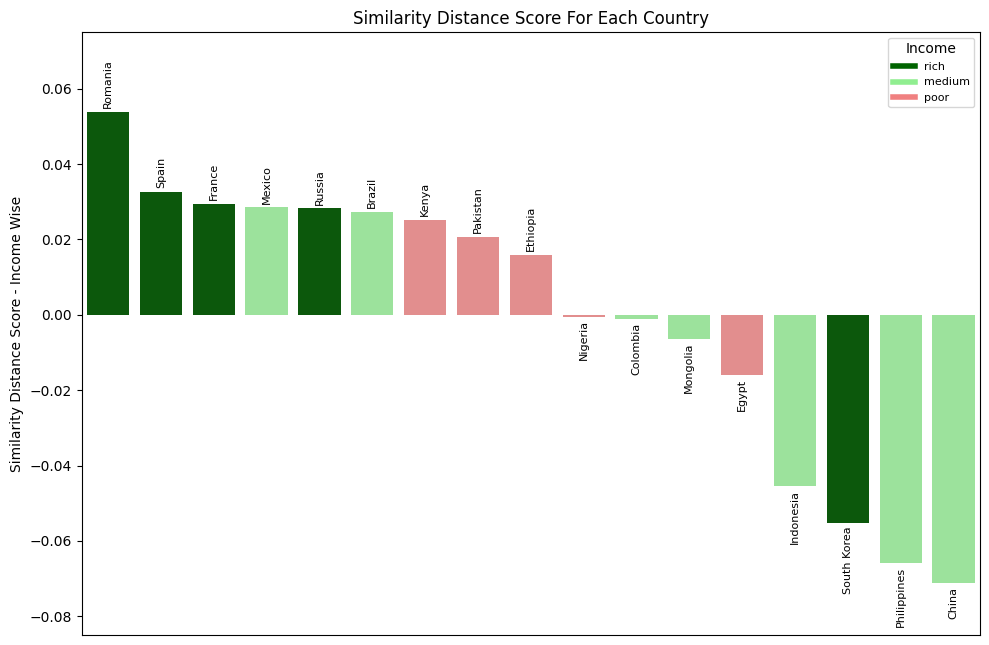

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

# Calculate the mean similarity value
origin = final_result_sorted['similarity'].mean()

# Sort data based on similarity
final_result_sorted = final_result_sorted.sort_values(by='similarity', ascending=False)

# Calculate deviation from the mean (center the bars at the mean similarity)
final_result_sorted['similarity_centered'] = final_result_sorted['similarity'] - origin

mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['income_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='similarity_centered',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
# plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

# Set the y-axis limits to highlight the range
plt.ylim(-0.085, 0.075)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Similarity Distance Score - Income Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Similarity Distance Score For Each Country')

# Display legend about color mapping. Top right corner. Label: income, color: color
# Display in a bo
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in category_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in category_palette.items()],
    title='Income',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


### Plot of Similarity Heatmap for each country (across all categories) - Region Wise

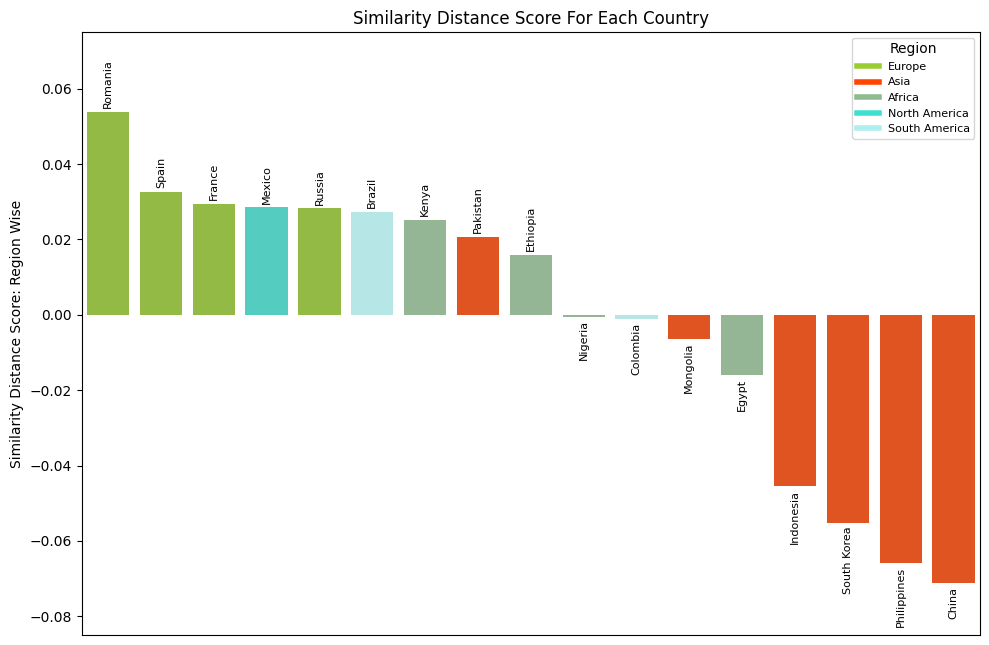

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

# Calculate the mean similarity value
origin = final_result_sorted['similarity'].mean()

# Sort data based on similarity
final_result_sorted = final_result_sorted.sort_values(by='similarity', ascending=False)

# Calculate deviation from the mean (center the bars at the mean similarity)
final_result_sorted['similarity_centered'] = final_result_sorted['similarity'] - origin

mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['region_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='similarity_centered',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
# plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

# Set the y-axis limits to highlight the range
plt.ylim(-0.085, 0.075)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Similarity Distance Score: Region Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Similarity Distance Score For Each Country')

# Display legend with color mapping. Top right corner. Label: region, color: color
# Display in a box
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in region_palette.items()],
    title='Region',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


### Plot For Normalized Similarity Distance

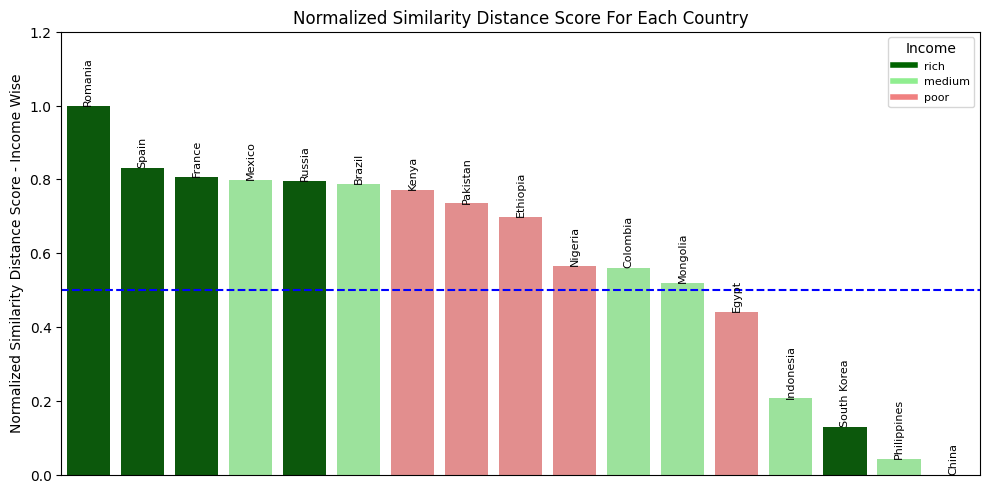

In [197]:
## Plot Normalzed Similarity Heatmap for each country

# import numpy as np
sim_values = final_result_sorted['similarity'].to_list()
min_sim = np.min(sim_values)
max_sim = np.max(sim_values)
rescaled_sim = [(sim - min_sim) / (max_sim - min_sim) for sim in sim_values]

final_result_sorted['rescaled_similarity'] = rescaled_sim

#---------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))


# Sort data based on rescaled imilarity
final_result_sorted = final_result_sorted.sort_values(by='rescaled_similarity', ascending=False)

# Map colors based on the category_group
# mapped_palette = final_result_sorted['country_group'].map(final_result_sorted['income_color'])
mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['income_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='rescaled_similarity',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
plt.axhline(0.5, color='blue', linestyle='--', label=f'Normalized Similarity')

# Set the y-axis limits to highlight the range
plt.ylim(0, 1.2)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Normalized Similarity Distance Score - Income Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Normalized Similarity Distance Score For Each Country')

# Display legend about color mapping. Top right corner. Label: income, color: color
# Display in a bo
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in category_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in category_palette.items()],
    title='Income',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


### Plot for Normalized Similarity Distance region wise

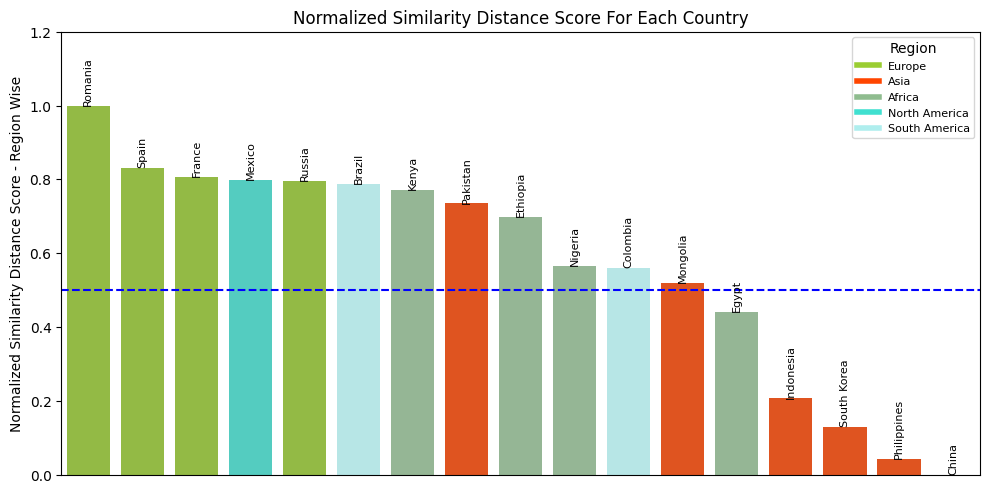

In [198]:
## Plot Normalzed Similarity Heatmap for each country

# import numpy as np
sim_values = final_result_sorted['similarity'].to_list()
min_sim = np.min(sim_values)
max_sim = np.max(sim_values)
rescaled_sim = [(sim - min_sim) / (max_sim - min_sim) for sim in sim_values]

final_result_sorted['rescaled_similarity'] = rescaled_sim

#---------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))


# Sort data based on rescaled imilarity
final_result_sorted = final_result_sorted.sort_values(by='rescaled_similarity', ascending=False)

# Map colors based on the category_group
# mapped_palette = final_result_sorted['country_group'].map(final_result_sorted['region_color'])
mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['region_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='rescaled_similarity',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
plt.axhline(0.5, color='blue', linestyle='--', label=f'Normalized Similarity: 0.5')

# Set the y-axis limits to highlight the range
plt.ylim(0, 1.2)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Normalized Similarity Distance Score - Region Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Normalized Similarity Distance Score For Each Country')

# Display legend
# Display legend about color mapping. Top right corner. Label: region, color: color
# Display in a bo
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in region_palette.items()],
    title='Region',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


---------------------------------------

## Computer JSD, SIM Per Category Per Countries

In [199]:
results = []

for f in files:
    data = pd.read_csv(os.path.join(directory, f))

    # Add category column to the DataFrame
    data['category'] = data['image_path'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[1:-2])
    data['category'] = data['category'].apply(lambda x: '_'.join(x))

    # Example gt and pred (list of lists)
    gt = [ast.literal_eval(x) for x in data['selection_answers'].tolist()]
    pred = [ast.literal_eval(x) for x in data['prob_percent_values'].tolist()]

    # Original DataFrame, retaining all columns from `data`
    df = data.copy()

    # Keep track of matching indices
    matching_indices = [i for i, (g, p) in enumerate(zip(gt, pred)) if len(g) == len(p)]

    # Filter rows where len(g) == len(p)
    filtered_gt_pred = [(g, p) for g, p in zip(gt, pred) if len(g) == len(p)]

    # If there are any matching rows
    if filtered_gt_pred:
        gt_filtered, pred_filtered = zip(*filtered_gt_pred)

        # Calculate JSD
        jsd = [distance.jensenshannon(g, p) for g, p in zip(gt_filtered, pred_filtered)]
        similarity = [1 - value for value in jsd]

        # Add JSD and similarity values back to the DataFrame
        df.loc[matching_indices, 'jsd'] = jsd
        df.loc[matching_indices, 'similarity'] = similarity
    else:
        df['jsd'] = None  # or handle the case accordingly
        df['similarity'] = None

    # Set JSD and similarity to NaN or a placeholder for rows that were filtered out
    df['jsd'] = pd.to_numeric(df['jsd'], errors='coerce')
    df['similarity'] = pd.to_numeric(df['similarity'], errors='coerce')

    # Calculate mean of jsd and similarity per country and per category
    mean_per_country_category = df.groupby(['country', 'category'])[['jsd', 'similarity']].mean().reset_index()

    # Append results to list
    results.append(mean_per_country_category)

# Combine all results into a single DataFrame
final_result = pd.concat(results, ignore_index=True)

In [200]:
final_result_sorted = final_result.set_index('country').loc[country_order].reset_index()
# Create a new column in the DataFrame for country category
final_result_sorted['category_group'] = final_result_sorted['country'].map(country_mapping)
final_result_sorted['category_color'] = final_result_sorted['category_group'].map(category_palette)

In [201]:
final_result_sorted['region'] = final_result_sorted['country'].map(country_regions)
final_result_sorted['region_color'] = final_result_sorted['region'].map(region_palette)

## Plot the Heatmap for Similarity for each category

In [202]:
income_dir = "income_category"
if not os.path.exists(income_dir):
    os.makedirs(income_dir)

# Plot similarity per category for all countries and save each plot
categories = final_result_sorted['category'].unique()

for category in categories:
    plt.figure(figsize=(12, 6))

    # Filter data for the current category (include all countries under this category)
    category_data = final_result_sorted[final_result_sorted['category'] == category]

    # # Drop NaNs in the similarity column
    # category_data = category_data.dropna(subset=['similarity'])

    # Sort data based on similarity for better visualization
    category_data = category_data.sort_values(by='similarity', ascending=False)

    # Calculate the mean similarity value for the current category across all countries
    origin = category_data['similarity'].mean()
    # print(f"origin: {origin}")

    # Calculate deviation from the mean (center the bars at the mean similarity)
    category_data['similarity_centered'] = category_data['similarity'] - origin

    # Map colors based on the category_group
    mapped_palette = category_data['category_group'].map(category_palette)

    # Ensure no missing values in the mapped palette
    if mapped_palette.isnull().any():
        print("Warning: Some category groups are not mapped to colors.")
        print(category_data[mapped_palette.isnull()])

    mapped_dict = dict(zip(category_data['country'], mapped_palette))
    # Plot vertical bar chart centered on the mean similarity
    bars = sns.barplot(
        x='country',
        y='similarity_centered',
        data=category_data,
        palette=mapped_dict
    )

    # Add a horizontal line for the centered mean (origin)
    plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

    # Set the y-axis limits to highlight the range
    plt.ylim(-0.065, 0.065)

    # Remove x-axis labels
    plt.xticks([])

    # Add labels and title
    plt.ylabel('Similarity Deviation from Mean')
    plt.xlabel('Country')
    plt.title(f'Countries by Deviation in Similarity from the Mean for Category: {category}')

    # Display legend
    # Display legend about color mapping. Top right corner. Label: income, color: color
    # Display in a box
    # Create custom legend handles
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in category_palette.values()]

    plt.legend(
        handles=legend_handles,
        labels=[f'{key}' for key, value in category_palette.items()],
        title='Income',
        loc='upper right',
        fontsize=8
    )

    # Annotate bars with the country names
    for bar, country in zip(bars.patches, category_data['country']):
        height = bar.get_height()
        # Place text slightly above the bar
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (0.01 if height >= 0 else -0.01),  # Adjust position based on height
            country,
            ha='center',
            va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
            fontsize=6,
            rotation=90  # Rotate text for better readability
        )
    # Save the plot as a file
    plt.savefig(f'{income_dir}/{category}.png', bbox_inches='tight')
    print(f"Saved category: {category}")

    # Close the plot to free memory
    plt.close()

Saved category: Brands
Saved category: Cooking_and_food
Saved category: Geography
Saved category: Objects
Saved category: People_and_everyday_life
Saved category: Public_Figure_and_pop_culture
Saved category: Traditions
Saved category: Vehicles_and_Transportation
Saved category: Sports_and_recreation
Saved category: Plants_and_animal


### Plot of Similarity Heatmap for each category (across all countries) - Region Wise

In [203]:
region_dir = "regions_categories"
if not os.path.exists(region_dir):
    os.makedirs(region_dir)

# Plot similarity per category for all countries and save each plot
for category in categories:
    plt.figure(figsize=(12, 6))

    # Filter data for the current category (include all countries under this category)
    category_data = final_result_sorted[final_result_sorted['category'] == category]

    # # Drop NaNs in the similarity column
    # category_data = category_data.dropna(subset=['similarity'])

    # Sort data based on similarity for better visualization
    category_data = category_data.sort_values(by='similarity', ascending=False)

    # Calculate the mean similarity value for the current category across all countries
    origin = category_data['similarity'].mean()
    # print(f"origin: {origin}")

    # Calculate deviation from the mean (center the bars at the mean similarity)
    category_data['similarity_centered'] = category_data['similarity'] - origin

    # Map colors based on the category_group
    mapped_palette = category_data['region_color']

    # Ensure no missing values in the mapped palette
    if mapped_palette.isnull().any():
        print("Warning: Some category groups are not mapped to colors.")
        print(category_data[mapped_palette.isnull()])

    mapped_dict = dict(zip(category_data['country'], mapped_palette))
    # Plot vertical bar chart centered on the mean similarity
    bars = sns.barplot(
        x='country',
        y='similarity_centered',
        data=category_data,
        palette=mapped_dict
    )

    # Add a horizontal line for the centered mean (origin)
    # plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

    # Set the y-axis limits to highlight the range
    plt.ylim(-0.065, 0.065)

    # Remove x-axis labels
    plt.xticks([])

    # Add labels and title
    plt.ylabel('Similarity Deviation from Mean')
    plt.xlabel('Country')
    plt.title(f'Countries by Deviation in Similarity from the Mean for Category: {category}')

    # Display legend
    # Display legend about color mapping. Top right corner. Label: region, color: color
    # Display in a box
    # Create custom legend handles
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_palette.values()]

    plt.legend(
        handles=legend_handles,
        labels=[f'{key}' for key, value in region_palette.items()],
        title='Region',
        loc='upper right',
        fontsize=8
    )

    # Annotate bars with the country names
    for bar, country in zip(bars.patches, category_data['country']):
        height = bar.get_height()
        # Place text slightly above the bar
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (0.01 if height >= 0 else -0.01),  # Adjust position based on height
            country,
            ha='center',
            va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
            fontsize=6,
            rotation=90  # Rotate text for better readability  
        )

    # Save the plot as a file
    plt.savefig(f'{region_dir}/similarity_per_category_{category}.png', bbox_inches='tight')
    print(f"Saved category: {category}")

    # Close the plot to free memory
    plt.close()

Saved category: Brands
Saved category: Cooking_and_food
Saved category: Geography
Saved category: Objects
Saved category: People_and_everyday_life
Saved category: Public_Figure_and_pop_culture
Saved category: Traditions
Saved category: Vehicles_and_Transportation
Saved category: Sports_and_recreation
Saved category: Plants_and_animal


-----------------------------------------------------------------------